<a href="https://colab.research.google.com/github/TransparentDeveloper/Dacon_Challenge/blob/main/%5BDacon%5D%EB%89%B4%EC%8A%A4_%ED%86%A0%ED%94%BD_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리 불러오기

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 46.3 MB/s 


In [277]:
import os
import pandas as pd
import re
import numpy as np
from konlpy.tag import Okt
from tqdm import tqdm
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt

#데이터 불러오기

In [140]:
pwd

'/content/drive/MyDrive/Dacon_Data/News_Topic'

In [141]:
cd './drive/MyDrive/Dacon_Data/News_Topic'

[Errno 2] No such file or directory: './drive/MyDrive/Dacon_Data/News_Topic'
/content/drive/MyDrive/Dacon_Data/News_Topic


In [282]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#데이터 살펴보기

In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [144]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   9131 non-null   int64 
 1   title   9131 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


In [145]:
train.head(20)

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4
6,6,인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보,4
7,7,美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과,4
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적,4


In [146]:
test.head(20)

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
5,45659,야외서 생방송 하세요…액션캠 전용 요금제 잇따라
6,45660,월드컵 태극전사 16강 전초기지 레오강 입성종합
7,45661,미세먼지 속 출근길
8,45662,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보
9,45663,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장


#정규표현식 + 불용언처리

In [147]:
train['title'] = train['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-핳]','')
test['title'] = test['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-핳]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [148]:
stopWords = ["을","를","에","게","에게","은","는","이","가","이다","서","에서",
             "다","부터","까지","혹시","까","일까","나","어찌","설마","외","이외",
             "이대로","아무","것","하다","으로","결국","즉","와","과","같이","의","로"]

In [149]:
okt = Okt()

In [150]:
X_train = []
for sentence, i in zip(train['title'],tqdm(range(len(train['title'])))) :
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True)
  temp_X = [word for word in temp_X if not word in stopWords if len(word)>1]
  X_train.append(temp_X)

100%|█████████▉| 45653/45654 [06:42<00:00, 113.31it/s]


In [151]:
for i in range(30):
  print(X_train[i])

['인천', '핀란드', '항공', '기결', '여객', '분통']
['실리콘밸리', '넘어서다', '구글', '조원', '전역', '거점']
['이란', '외무', '긴장', '완결', '미국', '이경제', '전쟁', '멈추다']
['클린턴', '기업', '특수', '관계', '조명', '공과', '맞다', '물리다', '종합']
['시진핑', '트럼프', '중미', '무역', '타결']
['팔레스타인', '가자지구', '서다', '소년', '이스라엘군', '총격', '사망']
['인도', '만에', '파키스탄', '공습', '테러', '캠프', '폭격', '종합']
['대선', '토론', '음담패설', '실패', '트럼프', '사과', '대신', '빌다', '클린턴', '공격']
['푸틴', '한반도', '상진', '전위', '방안', '김정은', '위원장', '논의']
['특검', '면죄부', '받다', '트럼프', '스캔들', '보도', '언론', '국민', '의적']
['오키나와', '열리다', '강제', '징용', '노동자', '추도']
['이란', '최고', '지도자', '모욕', '미국인', '징역', '선고']
['카니발', '축제', '보다', '브라질', '리우', '유람선']
['올랜도', '병원', '최악', '테러', '부상', '치료', '비다', '받다']
['대기업', '평균', '임금', '인상']
['엘니뇨', '강력', '분기', '소멸', '되다']
['이스라엘', '네타냐', '유대교도', '병역', '문제', '정상', '진통']
['사우디', '어르다', '연합', '참여', '키로']
['사우디', '오만', '유조선', '공격', '예멘', '반군', '연결', '이란', '겨냥']
['개천', '나와라', '사업가', '모교', '천억원', '장학금', '기부']
['브렉', '시트', '합의', '전야', '많다', '경고']
['스팍스', '운용', '디플레', '벗어나다', '새롭다', '도약', '준비'

In [152]:
X_test = []
for sentence, i in zip(test['title'],tqdm(range(len(test['title'])))) :
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True)
  temp_X = [word for word in temp_X if not word in stopWords if len(word)>1]
  X_test.append(temp_X)

100%|█████████▉| 9130/9131 [01:19<00:00, 115.40it/s]


In [153]:
for i in range(30):
  print(X_test[i])

['유튜브', '내달', '크리에이터', '원공', '운영']
['어버이날', '맑다', '가려지다', '남부', '지방', '옅다']
['내년', '국가', '평가', '논문', '건수', '반영', '않다']
['김명자', '신임', '총장', '원로', '젊다', '과학자', '모으다']
['색인', '작가', '동식', '양심', '고백', '소설', '집권', '추다']
['야외', '생방송', '액션', '전용', '금제', '잇따르다']
['월드컵', '태극전사', '강전', '초기', '지레', '오강', '입성', '종합']
['미세먼지', '출근길']
['왓츠앱', '성나다', '레바논', '민심', '총리', '사퇴', '이어지다', '종합']
['베트남', '성장', '지속', '기성']
['그리스', '국전', '참전', '기념', '참전용사', '한반도', '기원']
['정진석', '이정', '당실', '냉정하다', '보다', '물러나다', '좋다', '종합']
['베네수엘라', '반입', '촉구', '안보리', '결의', '추진']
['재균', '쐐기', '갈다', '바쁘다', '삼성', '고춧가루']
['정상', '대통령', '취임', '남북관계', '주요', '일지']
['분기', '영업', '천억원', '마케팅', '비용', '감소', '종합']
['박원순', '시장', '아부다비', '루브르', '박물관', '방문']
['방심위', '강릉', '고성', '산불', '처럼', '보도', '관계자', '징계']
['파키스탄', '경제', '카타르', '달러', '투자', '유치']
['예산', '팽창', '재정', '건전성', '우려', '내년', '장기', '채무']
['칠레', '민중', '하고', '미국', '피전', '법정', '에선']
['온라인', '중국인', '비자', '신청', '받다']
['밉다', '동부', '마비', '시키다', '악성', '파일', '국내', '서도', '발견']
['국내', '발간', '나노

In [154]:
# X_train, X_test 임시 저장
with open('/content/drive/MyDrive/Dacon_Data/News_Topic/picle_temp/X_train.pkl','wb') as f:
    pickle.dump(X_train,f)
with open('/content/drive/MyDrive/Dacon_Data/News_Topic/picle_temp/X_test.pkl','wb') as f:
    pickle.dump(X_test,f)

#토큰화

In [248]:
with open('/content/drive/MyDrive/Dacon_Data/News_Topic/picle_temp/X_train.pkl','rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/Dacon_Data/News_Topic/picle_temp/X_test.pkl','rb') as f:
    X_test = pickle.load(f)

In [249]:
vocab_size = 2000
tokenizer = Tokenizer(vocab_size,oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [250]:
print(word_index)

{'<OOV>': 1, '종합': 2, '대통령': 3, '한국': 4, '되다': 5, '이란': 6, '감독': 7, '보다': 8, '없다': 9, '출시': 10, '게시판': 11, '트럼프': 12, '만에': 13, '신간': 14, '정부': 15, '투자': 16, '개발': 17, '정상': 18, '최고': 19, '중국': 20, '영업': 21, '개최': 22, '민주': 23, '분기': 24, '기업': 25, '억원': 26, '기술': 27, '미국': 28, '증권': 29, '크다': 30, '금융': 31, '대표': 32, '작년': 33, '공개': 34, '코로나': 35, '총리': 36, '최대': 37, '김정은': 38, '북한': 39, '서비스': 40, '축제': 41, '돼다': 42, '시즌': 43, '게임': 44, '받다': 45, '터키': 46, '사망': 47, '사업': 48, '그래픽': 49, '전국': 50, '월드컵': 51, '류진': 52, '추진': 53, '않다': 54, '서울': 55, '부산': 56, '방문': 57, '지원': 58, '에도': 59, '국내': 60, '국민': 61, '갤럭시': 62, '남북': 63, '시장': 64, '세계': 65, '개다': 66, '네이버': 67, '장관': 68, '합의': 69, '경기': 70, '축구': 71, '맞다': 72, '꺾다': 73, '국제': 74, '연승': 75, '오다': 76, '논란': 77, '코스피': 78, '개막': 79, '시위': 80, '제재': 81, '전자': 82, '삼성': 83, '결정': 84, '선수': 85, '앞두다': 86, '기자': 87, '추다': 88, '산업': 89, '논의': 90, '가능성': 91, '달러': 92, '시리아': 93, '천억원': 94, '발표': 95, '유럽': 96, '프로농구': 97, '내년': 98, '주말': 99

In [251]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [252]:
for i in range(30):
  print(X_train[i])

[294, 1, 733, 1, 1759, 1]
[1, 1, 230, 734, 1200, 1]
[6, 443, 678, 1, 28, 1, 273, 1063]
[1, 25, 1172, 634, 1002, 1, 72, 1, 2]
[378, 12, 1, 262, 1815]
[1497, 1954, 342, 1064, 1, 679, 47]
[652, 13, 1462, 827, 175, 1121, 1, 2]
[206, 368, 1, 522, 12, 856, 869, 1, 1, 101]
[582, 392, 1, 1, 539, 38, 106, 90]
[583, 1, 45, 12, 1, 419, 133, 61, 1]
[1, 271, 1326, 1, 337, 1]
[6, 19, 689, 1, 1, 870, 1533]
[1, 41, 8, 562, 1, 1]
[1, 690, 976, 175, 148, 531, 714, 45]
[1201, 498, 954, 350]
[1, 828, 24, 1, 5]
[155, 829, 1, 1, 194, 18, 1]
[169, 1, 635, 272, 590]
[169, 1, 786, 101, 599, 549, 532, 6, 772]
[1, 1, 1, 1, 94, 1, 550]
[318, 300, 69, 1, 200, 452]
[1, 787, 1, 1, 481, 1649, 142]
[12, 1, 1327, 101, 1, 250, 1, 160, 2]
[1, 219, 1, 1, 435, 915]
[563, 3, 1, 885, 1, 671]
[413, 12, 15, 39, 18, 634, 533]
[155, 829, 6, 1, 1, 1, 212, 104]
[155, 829, 156, 86, 30, 57, 671]
[12, 147, 453, 1, 263, 857, 1760, 1]
[28, 89, 653, 13, 1, 1]


In [253]:
for i in range(30):
  print(X_test[i])

[1119, 143, 1, 1, 214]
[1, 1081, 1, 523, 721, 1]
[98, 195, 324, 1, 1, 1, 54]
[1, 427, 548, 1, 1034, 1, 1]
[1, 313, 1, 1, 1, 390, 726, 88]
[1, 1, 1, 648, 1104, 737]
[51, 1, 1, 1, 1, 1, 1, 2]
[341, 1]
[1, 1, 1094, 1423, 36, 579, 944, 2]
[276, 340, 592, 1]
[961, 1, 1, 173, 1, 392, 1]
[1, 1208, 1, 1, 8, 1, 180, 2]
[461, 1, 160, 1500, 604, 53]
[1, 1, 1176, 1, 83, 1]
[18, 3, 720, 1774, 492, 1]
[24, 21, 94, 1289, 1821, 149, 2]
[1578, 64, 1, 1, 650, 57]
[1, 1264, 1, 1532, 658, 419, 1, 603]
[1462, 295, 1, 92, 16, 875]
[709, 1, 1, 1, 179, 98, 919, 1]
[1, 1, 299, 28, 1, 1504, 540]
[239, 1248, 1, 314, 45]
[111, 1301, 1, 1126, 1, 1, 60, 1023, 246]
[60, 950, 1, 1, 1, 1, 1]
[793, 1054, 795, 374, 1, 1985, 265]
[1, 1319, 1, 1, 1, 587]
[665, 1, 325, 1, 1, 425, 9]
[439, 1, 1, 203, 468, 231]
[1, 1338, 1, 1, 1]
[249, 1, 1, 197, 1106, 251]


#패딩

In [255]:
max_len = 14
X_train = pad_sequences(X_train,padding='post',maxlen=max_len)
X_test=pad_sequences(X_test,padding='post',maxlen=max_len)

In [256]:
for i in range(5):
  print(X_train[i])

[ 294    1  733    1 1759    1    0    0    0    0    0    0    0    0]
[   1    1  230  734 1200    1    0    0    0    0    0    0    0    0]
[   6  443  678    1   28    1  273 1063    0    0    0    0    0    0]
[   1   25 1172  634 1002    1   72    1    2    0    0    0    0    0]
[ 378   12    1  262 1815    0    0    0    0    0    0    0    0    0]


In [257]:
for i in range(5):
  print(X_test[i])

[1119  143    1    1  214    0    0    0    0    0    0    0    0    0]
[   1 1081    1  523  721    1    0    0    0    0    0    0    0    0]
[ 98 195 324   1   1   1  54   0   0   0   0   0   0   0]
[   1  427  548    1 1034    1    1    0    0    0    0    0    0    0]
[  1 313   1   1   1 390 726  88   0   0   0   0   0   0]


In [259]:
print(X_train.shape, X_test.shape)

(45654, 14) (9131, 14)


In [260]:
y_train = to_categorical(train['topic_idx'])

In [262]:
print(y_train)
print(y_train.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


#모델링

In [268]:
model3 = Sequential([Embedding(vocab_size, 200, input_length =max_len),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 14, 200)           400000    
                                                                 
 bidirectional (Bidirectiona  (None, 14, 128)          135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 7)                 903       
                                                     

In [269]:
history = model3.fit(X_train, y_train, epochs=50, batch_size=100, validation_split= 0.2) 

Epoch 1/50
366/366 [==============================] - 39s 60ms/step - loss: 0.9618 - accuracy: 0.6481 - val_loss: 1.0940 - val_accuracy: 0.5999
Epoch 2/50
366/366 [==============================] - 14s 39ms/step - loss: 0.6646 - accuracy: 0.7747 - val_loss: 1.0159 - val_accuracy: 0.6309
Epoch 3/50
366/366 [==============================] - 14s 39ms/step - loss: 0.6183 - accuracy: 0.7913 - val_loss: 0.9974 - val_accuracy: 0.6402
Epoch 4/50
366/366 [==============================] - 14s 39ms/step - loss: 0.5783 - accuracy: 0.8046 - val_loss: 0.9755 - val_accuracy: 0.6430
Epoch 5/50
366/366 [==============================] - 14s 39ms/step - loss: 0.5473 - accuracy: 0.8125 - val_loss: 0.9689 - val_accuracy: 0.6537
Epoch 6/50
366/366 [==============================] - 14s 39ms/step - loss: 0.5199 - accuracy: 0.8203 - val_loss: 0.9594 - val_accuracy: 0.6651
Epoch 7/50
366/366 [==============================] - 15s 42ms/step - loss: 0.4888 - accuracy: 0.8308 - val_loss: 1.0728 - val_accuracy:

# 결과 확인

<function matplotlib.pyplot.show>

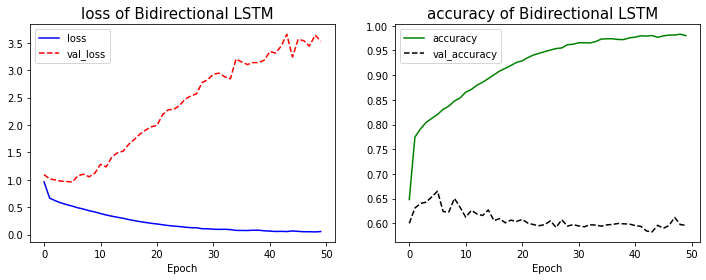

In [273]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM  ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM  ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

#결과 도출

In [275]:
y_pred=model3.predict(X_test) 
y_pred

array([[6.4757276e-01, 5.6790868e-03, 1.1128166e-03, ..., 2.9193242e-08,
        5.1890684e-06, 1.3764285e-03],
       [3.5439475e-12, 4.7311932e-09, 1.8915363e-09, ..., 1.4003264e-09,
        2.0837521e-09, 9.0955676e-10],
       [1.2029032e-07, 9.8023556e-06, 3.5730966e-07, ..., 1.2897087e-05,
        8.1879366e-09, 9.9997675e-01],
       ...,
       [3.8633880e-07, 9.4828025e-08, 8.0452606e-05, ..., 4.2829174e-03,
        6.8657728e-06, 3.8746766e-06],
       [9.9999702e-01, 4.1995230e-09, 2.4005280e-07, ..., 6.5411241e-09,
        5.2741124e-11, 2.6733524e-06],
       [3.0698754e-07, 7.5388261e-06, 9.7965473e-01, ..., 1.0083722e-02,
        4.9163680e-07, 9.7441617e-03]], dtype=float32)

In [278]:
topic = []
for i in range(len(y_pred)):
    topic.append(np.argmax(y_pred[i]))

In [283]:
sample_submission['topic_idx'] = topic

In [284]:
sample_submission.head(10)

,index,topic_idx
0,45654,0
1,45655,3
2,45656,6
3,45657,2
4,45658,3
5,45659,0
6,45660,5
7,45661,3
8,45662,4
9,45663,4


In [285]:
sample_submission.to_csv('submission.csv', index = False, encoding = 'utf-8')